In [ ]:
### Routine per il fine tuning del modello 

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import (
    train_test_split, 
    GridSearchCV, 
    RandomizedSearchCV,
    
    StratifiedKFold
)
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    accuracy_score,
    precision_recall_fscore_support,
    roc_auc_score
)

import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Leggi i dati e le etichette dai file Parquet nella cartella preprocessed/binary/data_w_features
features_df = pd.read_parquet('processed_data/binary_classification/data_w_features/combined_features.parquet')
labels_df = pd.read_parquet('processed_data/binary_classification/data_w_features/labels_binary_stats_features_only.parquet')

# Campiona 10000 righe con distribuzione bilanciata tra le classi di labels_df
n_samples_per_class = 20000  # 10000/2 per due classi
sampled_indices = (
    labels_df.groupby(labels_df.iloc[:, 0])
    .apply(lambda x: x.sample(n=n_samples_per_class, random_state=42))
    .index.get_level_values(1)
)
features_df = features_df.loc[sampled_indices].reset_index(drop=True)
labels_df = labels_df.loc[sampled_indices].reset_index(drop=True)

In [22]:
len(features_df), len(labels_df)

(10000, 10000)

In [23]:
from collections import Counter
Counter(labels_df.iloc[:, 0])

Counter({0: 5000, 1: 5000})

In [ ]:
class RandomForestTuner:
    def __init__(self, features_df, labels_df, target_column='O', test_size=0.2, random_state=42):
        """
        Inizializza il tuner per Random Forest
        
        Args:
            features_df: DataFrame con le features
            labels_df: DataFrame con le labels
            target_column: nome della colonna target
            test_size: proporzione del test set
            random_state: seed per riproducibilità
        """
        self.features_df = features_df
        self.labels_df = labels_df
        self.target_column = target_column
        self.test_size = test_size
        self.random_state = random_state
        
        # Inizializza attributi
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.best_model = None
        self.best_params = None
        self.cv_results = None
        
    def prepare_data(self):
        """Prepara i dati per il training"""
        print("Preparazione dei dati...")
        
        # Estrai features e target
        X = self.features_df.copy()
        y = self.labels_df[self.target_column].copy()
        
        # Gestisci valori mancanti
        X = X.fillna(X.median() if X.select_dtypes(include=[np.number]).shape[1] > 0 else X.mode().iloc[0])
        
        # Encoding delle variabili categoriche se presenti
        categorical_columns = X.select_dtypes(include=['object']).columns
        if len(categorical_columns) > 0:
            print(f"Encoding di {len(categorical_columns)} variabili categoriche")
            for col in categorical_columns:
                le = LabelEncoder()
                X[col] = le.fit_transform(X[col].astype(str))
        
        # Split train/test
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X, y, test_size=self.test_size, random_state=self.random_state, 
            stratify=y if len(np.unique(y)) > 1 else None
        )
        
        print(f"Dimensioni training set: {self.X_train.shape}")
        print(f"Dimensioni test set: {self.X_test.shape}")
        print("Distribuzione classi nel training set:")
        print(self.y_train.value_counts().sort_index())
        
    def define_param_grids(self):
        """Definisce le griglie di parametri per la ricerca"""
        
        # Griglia completa per GridSearch (più lenta ma esaustiva)
        self.grid_params = {
            'n_estimators': [100, 200, 300],
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_features': ['sqrt', 'log2', None],
            'bootstrap': [True, False]
        }
        
        # Griglia per RandomizedSearch (più veloce)
        self.random_params = {
            'n_estimators': stats.randint(50, 500),
            'max_depth': [None] + list(range(10, 50, 5)),
            'min_samples_split': stats.randint(2, 20),
            'min_samples_leaf': stats.randint(1, 10),
            'max_features': ['sqrt', 'log2', None, 0.5, 0.7, 0.9],
            'bootstrap': [True, False],
            'max_samples': [None, 0.7, 0.8, 0.9] if True else [None]  # Solo se bootstrap=True
        }
        
    def grid_search_tuning(self, cv_folds=5, scoring='accuracy', n_jobs=-1):
        """
        Esegue Grid Search per trovare i parametri ottimali
        
        Args:
            cv_folds: numero di fold per cross-validation
            scoring: metrica di scoring
            n_jobs: numero di processi paralleli
        """
        print("\n=== GRID SEARCH TUNING ===")
        print("Avvio Grid Search (può richiedere diversi minuti)...")
        
        # Definisci il modello base
        rf = RandomForestClassifier(random_state=self.random_state)
        
        # Setup cross-validation
        cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=self.random_state)
        
        # Grid Search
        grid_search = GridSearchCV(
            estimator=rf,
            param_grid=self.grid_params,
            cv=cv,
            scoring=scoring,
            n_jobs=n_jobs,
            verbose=1,
            return_train_score=True
        )
        
        # Fit del modello
        grid_search.fit(self.X_train, self.y_train)
        
        # Salva i risultati
        self.best_model = grid_search.best_estimator_
        self.best_params = grid_search.best_params_
        self.cv_results = pd.DataFrame(grid_search.cv_results_)
        
        print("\nMigliori parametri trovati:")
        for param, value in self.best_params.items():
            print(f"  {param}: {value}")
        print(f"\nMiglior score CV: {grid_search.best_score_:.4f}")
        
        return grid_search
    
    def randomized_search_tuning(self, n_iter=100, cv_folds=5, scoring='accuracy', n_jobs=-1):
        """
        Esegue Randomized Search per trovare i parametri ottimali
        
        Args:
            n_iter: numero di combinazioni di parametri da testare
            cv_folds: numero di fold per cross-validation
            scoring: metrica di scoring
            n_jobs: numero di processi paralleli
        """
        print("\n=== RANDOMIZED SEARCH TUNING ===")
        print(f"Avvio Randomized Search con {n_iter} iterazioni...")
        
        # Definisci il modello base
        rf = RandomForestClassifier(random_state=self.random_state)
        
        # Setup cross-validation
        cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=self.random_state)
        
        # Randomized Search
        random_search = RandomizedSearchCV(
            estimator=rf,
            param_distributions=self.random_params,
            n_iter=n_iter,
            cv=cv,
            scoring=scoring,
            n_jobs=n_jobs,
            verbose=1,
            random_state=self.random_state,
            return_train_score=True
        )
        
        # Fit del modello
        random_search.fit(self.X_train, self.y_train)
        
        # Salva i risultati
        self.best_model = random_search.best_estimator_
        self.best_params = random_search.best_params_
        self.cv_results = pd.DataFrame(random_search.cv_results_)
        
        print("\nMigliori parametri trovati:")
        for param, value in self.best_params.items():
            print(f"  {param}: {value}")
        print(f"\nMiglior score CV: {random_search.best_score_:.4f}")
        
        return random_search
    
    def evaluate_model(self, plot_results=True):
        """Valuta il modello ottimizzato"""
        if self.best_model is None:
            print("Errore: Nessun modello è stato addestrato ancora!")
            return
        
        print("\n=== VALUTAZIONE DEL MODELLO ===")
        
        # Predizioni
        y_pred = self.best_model.predict(self.X_test)
        y_pred_proba = self.best_model.predict_proba(self.X_test)
        
        # Metriche di base
        accuracy = accuracy_score(self.y_test, y_pred)
        precision, recall, f1, _ = precision_recall_fscore_support(self.y_test, y_pred, average='weighted')
        
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1-Score: {f1:.4f}")
        
        # ROC AUC per problemi binari o multiclasse
        try:
            if len(np.unique(self.y_test)) == 2:
                auc = roc_auc_score(self.y_test, y_pred_proba[:, 1])
                print(f"ROC AUC: {auc:.4f}")
            else:
                auc = roc_auc_score(self.y_test, y_pred_proba, multi_class='ovr')
                print(f"ROC AUC (multiclass): {auc:.4f}")
        except:
            print("ROC AUC non calcolabile")
        
        # Classification report dettagliato
        print("\nClassification Report:")
        print(classification_report(self.y_test, y_pred))
        
        # Feature importance
        if hasattr(self.best_model, 'feature_importances_'):
            feature_importance = pd.DataFrame({
                'feature': self.X_train.columns,
                'importance': self.best_model.feature_importances_
            }).sort_values('importance', ascending=False)
            
            print("\nTop 10 Feature più importanti:")
            print(feature_importance.head(10))
        
        # Plot dei risultati
        if plot_results:
            self.plot_results(y_pred, feature_importance if 'feature_importance' in locals() else None)
        
        return {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'predictions': y_pred,
            'probabilities': y_pred_proba
        }
    
    def plot_results(self, y_pred, feature_importance=None):
        """Crea visualizzazioni dei risultati"""
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        
        # 1. Confusion Matrix
        cm = confusion_matrix(self.y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0,0])
        axes[0,0].set_title('Confusion Matrix')
        axes[0,0].set_xlabel('Predicted')
        axes[0,0].set_ylabel('Actual')
        
        # 2. Feature Importance
        if feature_importance is not None:
            top_features = feature_importance.head(15)
            axes[0,1].barh(range(len(top_features)), top_features['importance'])
            axes[0,1].set_yticks(range(len(top_features)))
            axes[0,1].set_yticklabels(top_features['feature'])
            axes[0,1].set_title('Top 15 Feature Importance')
            axes[0,1].set_xlabel('Importance')
        
        # 3. Cross-validation scores
        if self.cv_results is not None:
            cv_scores = self.cv_results['mean_test_score']
            axes[1,0].hist(cv_scores, bins=30, alpha=0.7, color='skyblue')
            axes[1,0].axvline(cv_scores.max(), color='red', linestyle='--', 
                             label=f'Best: {cv_scores.max():.4f}')
            axes[1,0].set_title('Distribuzione CV Scores')
            axes[1,0].set_xlabel('CV Score')
            axes[1,0].set_ylabel('Frequency')
            axes[1,0].legend()
        
        # 4. Distribuzione classi predette vs reali
        comparison_df = pd.DataFrame({
            'Actual': self.y_test,
            'Predicted': y_pred
        })
        
        actual_counts = comparison_df['Actual'].value_counts().sort_index()
        pred_counts = comparison_df['Predicted'].value_counts().sort_index()
        
        x_pos = np.arange(len(actual_counts))
        width = 0.35
        
        axes[1,1].bar(x_pos - width/2, actual_counts.values, width, 
                     label='Actual', alpha=0.8)
        axes[1,1].bar(x_pos + width/2, pred_counts.values, width, 
                     label='Predicted', alpha=0.8)
        axes[1,1].set_title('Distribuzione Classi: Actual vs Predicted')
        axes[1,1].set_xlabel('Classe')
        axes[1,1].set_ylabel('Count')
        axes[1,1].set_xticks(x_pos)
        axes[1,1].set_xticklabels(actual_counts.index)
        axes[1,1].legend()
        
        plt.tight_layout()
        plt.show()
    
    def run_complete_pipeline(self, search_type='randomized', **kwargs):
        """
        Esegue la pipeline completa di tuning
        
        Args:
            search_type: 'grid' o 'randomized'
            **kwargs: parametri aggiuntivi per la ricerca
        """
        print("🚀 AVVIO PIPELINE COMPLETA DI TUNING")
        print("="*50)
        
        # 1. Preparazione dati
        self.prepare_data()
        
        # 2. Definizione parametri
        self.define_param_grids()
        
        # 3. Ricerca parametri
        if search_type.lower() == 'grid':
            search_results = self.grid_search_tuning(**kwargs)
        else:
            search_results = self.randomized_search_tuning(**kwargs)
        
        # 4. Valutazione finale
        evaluation_results = self.evaluate_model()
        
        print("\n🎉 PIPELINE COMPLETATA!")
        return search_results, evaluation_results

# ================================
# ESEMPIO DI UTILIZZO
# ================================

def main_example():
    """Esempio di utilizzo della pipeline"""
    
    # Assumendo che hai già features_df e labels_df
    # features_df = your_features_dataframe
    # labels_df = your_labels_dataframe
    
    # Inizializza il tuner
    tuner = RandomForestTuner(
        features_df=features_df, 
        labels_df=labels_df, 
        target_column='0',
        test_size=0.2,
        random_state=42
    )
    
    # Opzione 1: Pipeline completa con Randomized Search (raccomandato)
    search_results, eval_results = tuner.run_complete_pipeline(
        search_type='randomized',
        n_iter=50,  # Riduci per test più veloci
        cv_folds=5,
        scoring='accuracy',
        n_jobs=-1
    )
    
    # Opzione 2: Pipeline completa con Grid Search (più lenta)
    # search_results, eval_results = tuner.run_complete_pipeline(
    #     search_type='grid',
    #     cv_folds=3,  # Riduci per velocizzare
    #     scoring='f1_weighted',
    #     n_jobs=-1
    # )
    
    # Accesso ai risultati
    print(f"\nMiglior modello: {tuner.best_model}")
    print(f"Migliori parametri: {tuner.best_params}")
    
    return tuner

# Per eseguire la pipeline, decommentare:


🚀 AVVIO PIPELINE COMPLETA DI TUNING
Preparazione dei dati...
Dimensioni training set: (8000, 134)
Dimensioni test set: (2000, 134)
Distribuzione classi nel training set:
0
0    4000
1    4000
Name: count, dtype: int64

=== RANDOMIZED SEARCH TUNING ===
Avvio Randomized Search con 50 iterazioni...
Fitting 5 folds for each of 50 candidates, totalling 250 fits

Migliori parametri trovati:
  bootstrap: True
  max_depth: 40
  max_features: None
  max_samples: 0.7
  min_samples_leaf: 1
  min_samples_split: 5
  n_estimators: 99

Miglior score CV: 0.8216

=== VALUTAZIONE DEL MODELLO ===
Accuracy: 0.8335
Precision: 0.8364
Recall: 0.8335
F1-Score: 0.8331
ROC AUC: 0.9131

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.79      0.83      1000
           1       0.81      0.88      0.84      1000

    accuracy                           0.83      2000
   macro avg       0.84      0.83      0.83      2000
weighted avg       0.84      0.83   

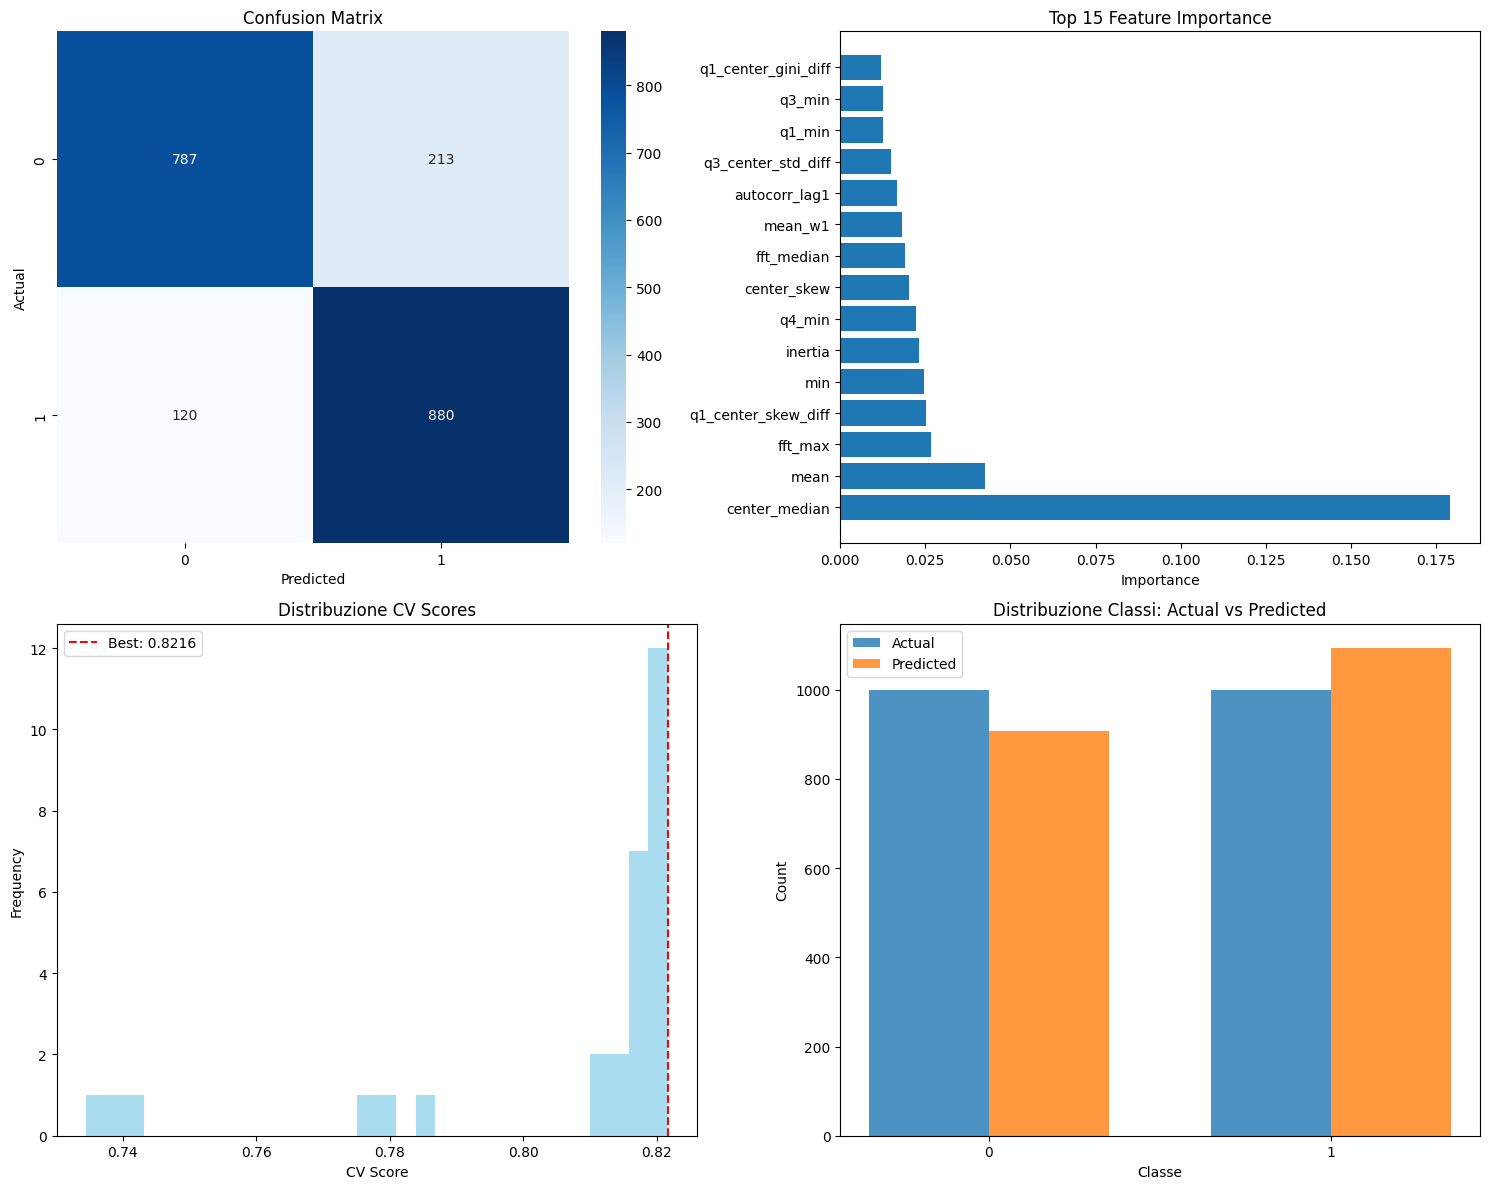


🎉 PIPELINE COMPLETATA!

Miglior modello: RandomForestClassifier(max_depth=40, max_features=None, max_samples=0.7,
                       min_samples_split=5, n_estimators=99, random_state=42)
Migliori parametri: {'bootstrap': True, 'max_depth': 40, 'max_features': None, 'max_samples': 0.7, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 99}


In [25]:
tuner = main_example()